# *Voxel microFE pipeline - trabecular bone samples*
From micro-CT image to voxel-uFE model solution in ParOSol

Created on:  23.05.2021 <br />
Last update: 02.05.2024 <br />

- By: [Gianluca Iori](https://github.com/gianthk), Martino Pani, [Gianluigi Crimi](https://github.com/gcrimi), Enrico Schileo, Fulvia Taddei, Giulia Fraterrigo, Alfonso Dario Santamaria 2024
- Data source: the dataset used in this example is part of the public collection of the Living Human Digital Library (LHDL) Project, a project financed by the European Commission (project number: [FP6-IST 026932](https://cordis.europa.eu/project/id/026932)). Human tissues in the LHDL project were collected according to the body donation program of Universitè Libre de Bruxelles (ULB), partner of the project. For info on the dataset see [here](http://projects.kmi.open.ac.uk/lhdl/).
- Code license: MIT
- Narrative license: CC-BY-NC-SA

---
## Aims
![](./../../fem_pipeline.png)
The example implements the following ciclope pipeline:
1. Load and inspect microCT volume data
2. Image pre-processing
    - Apply Gaussian smooth (optional)
    - Resample the dataset (optional)
    - Segment bone tissue
    - Remove unconnected clusters of voxels
3. Generate voxel-FE model from the binarized microCT image for ParOSol
    - Generate file .h5
    - Linear, static analysis definition: uniaxial compression test
5. Launch simulation in ParoSOl. For info on the solver visit the [parosol-tu-wien GitHub](https://github.com/reox/parosol-tu-wien)
6. Convert ParOSol output to .VTK for visualization in Paraview
7. Calculate apparent elastic modulus from reaction forces

---
### Notes on ciclope
* All mesh exports are performed with the [meshio](https://github.com/nschloe/meshio) module.
* **ciclope** handles the definition of material properties and FE analysis parameters (e.g. boundary conditions, simulation steps..) through separate template files. The folders [material_properties](https://github.com/gianthk/ciclope/tree/master/material_properties) and [input_templates](https://github.com/gianthk/ciclope/tree/master/input_templates) contain a library of template files that can be used to generate FE simulations.
  * Additional libraries of [ParOSol](https://github.com/reox/parosol-tu-wien) file format info can be found [here](https://github.com/reox/parosol-tu-wien/blob/master/doc/file_format.md)

---
## Configuration and imports

In [1]:
import sys
sys.path.append('./../../')

In [2]:
import os
import numpy as np
import matplotlib
import matplotlib.pyplot as plt

import mcubes
from scipy import ndimage, misc
import scipy.ndimage as ndi
from skimage.filters import threshold_otsu, gaussian
from skimage import measure, morphology
import meshio
import time
import math
import h5py

from ciclope.utils.recon_utils import read_tiff_stack, plot_midplanes, touint8
from ciclope.utils.preprocess import remove_unconnected, invert_images, convert_bmp_to_tiff, crop_and_resize_images
from ciclope.utils.postprocess import calculate_total_force, circular_masks_BVTV, reaction_forces
from ciclope.core import voxelFE
import ciclope

Uncomment and run the following cell for visualizations using [itkwidgets](https://github.com/InsightSoftwareConsortium/itkwidgets)

In [3]:
#import itk
#from itkwidgets import view
#import vtk

[ccx2paraview](https://github.com/calculix/ccx2paraview) is needed for the postprocessing of results

In [4]:
matplotlib.rcParams['figure.dpi'] = 300

font = {'weight' : 'normal',
        'size'   : 6}

plt.rc('font', **font)

#### Load input data

In [5]:
input_file = './../../test_data/LHDL/3155_D_4_bc/cropped/3155_D_4_bc_0000.tif'

Input data description

|Scan parameters|   |
|:-|:-|
|Lab|LTM@IOR Bologna|
|Sample|Human trabecular bone|
|Voxel size|19.5 micron|
|Preliminary operations|Cropped to 200x200x200 (4mm side)|

Read the input data and define an array of the voxelsize

In [6]:
data_3D = read_tiff_stack(input_file)
vs = np.ones(3)*19.5e-3 # [mm]

Inspect the dataset

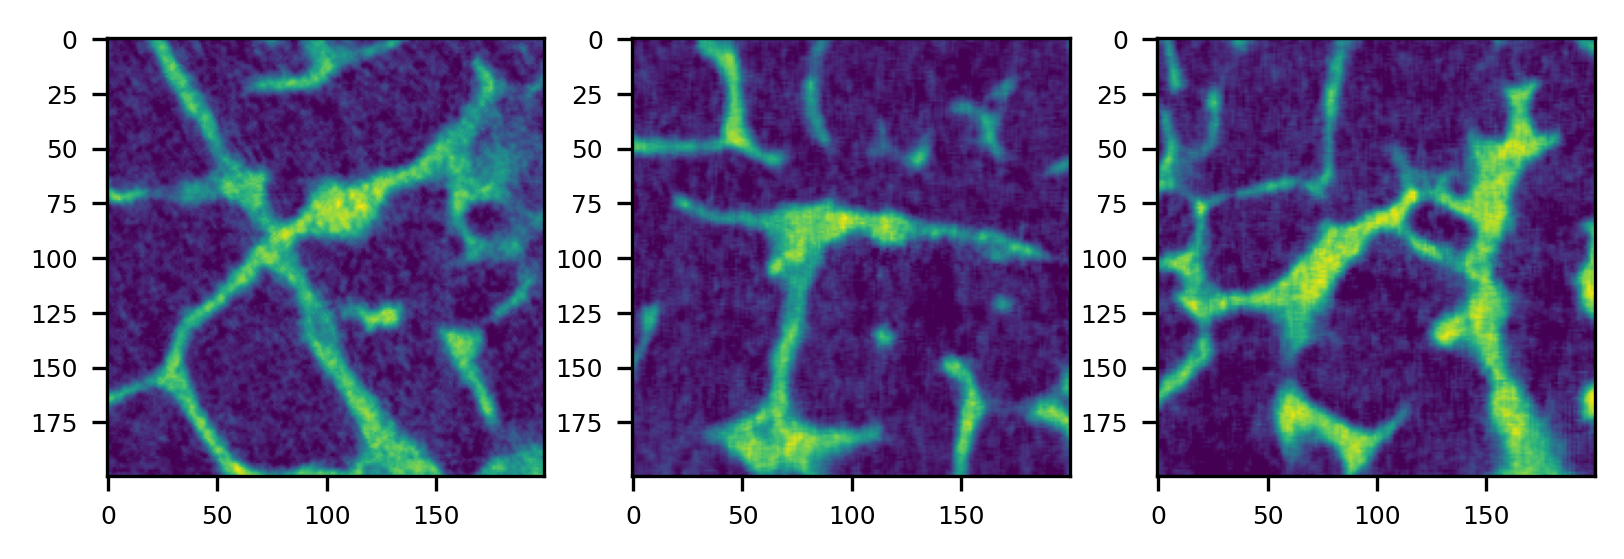

In [7]:
plot_midplanes(data_3D)
plt.show()

Inspect the dataset with [itkwidgets](https://github.com/InsightSoftwareConsortium/itkwidgets)

In [8]:
#viewer = view(data_3D, ui_collapsed=True)
#viewer.interpolation = False

Launch itk viewer

In [9]:
#viewer

## Pre-processing
### Gaussian smooth

In [10]:
data_3D = gaussian(data_3D, sigma=1, preserve_range=True)

### Resize (optional)

In [11]:
#resampling = 2

# resize the 3D data using spline interpolation of order 2
#data_3D = ndimage.zoom(data_3D, 1/resampling, output=None, order=2)

# correct voxelsize
#vs = vs * resampling

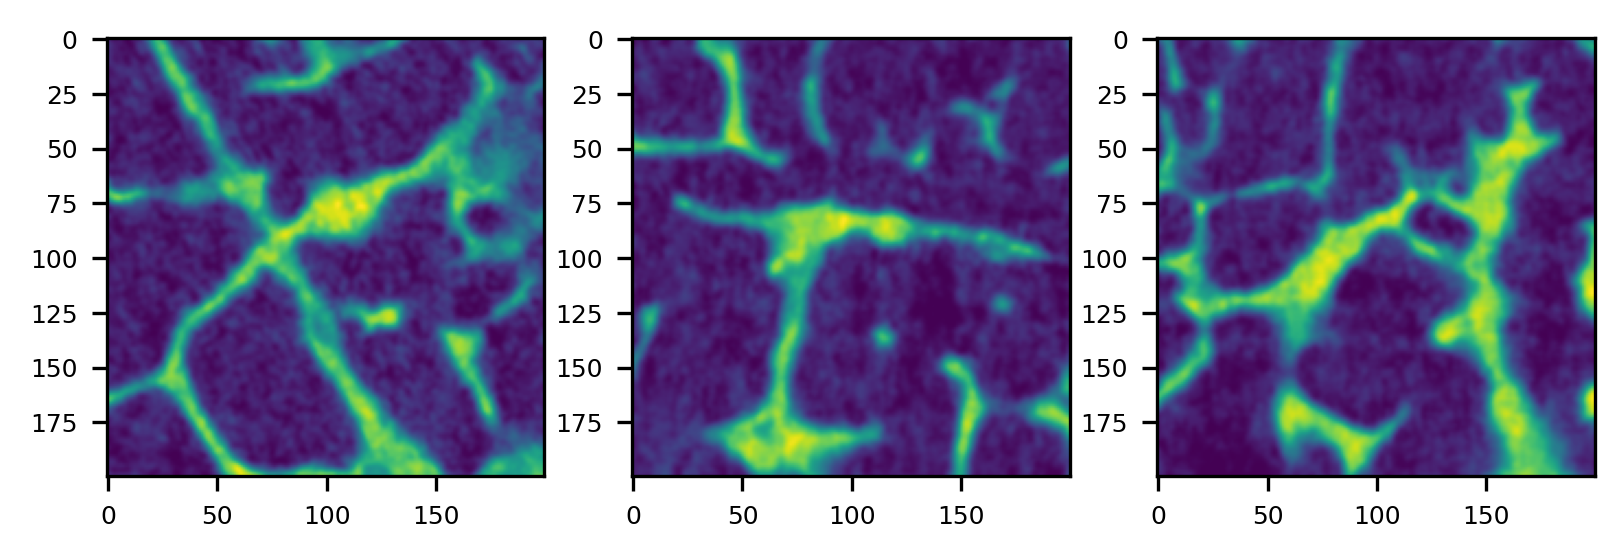

In [12]:
# Inspect again the dataset
plot_midplanes(data_3D)
plt.show()

### Thresholding
Use Otsu's method

In [13]:
T = threshold_otsu(data_3D)
print("Threshold: {}".format(T))

Threshold: 80.92566349845595


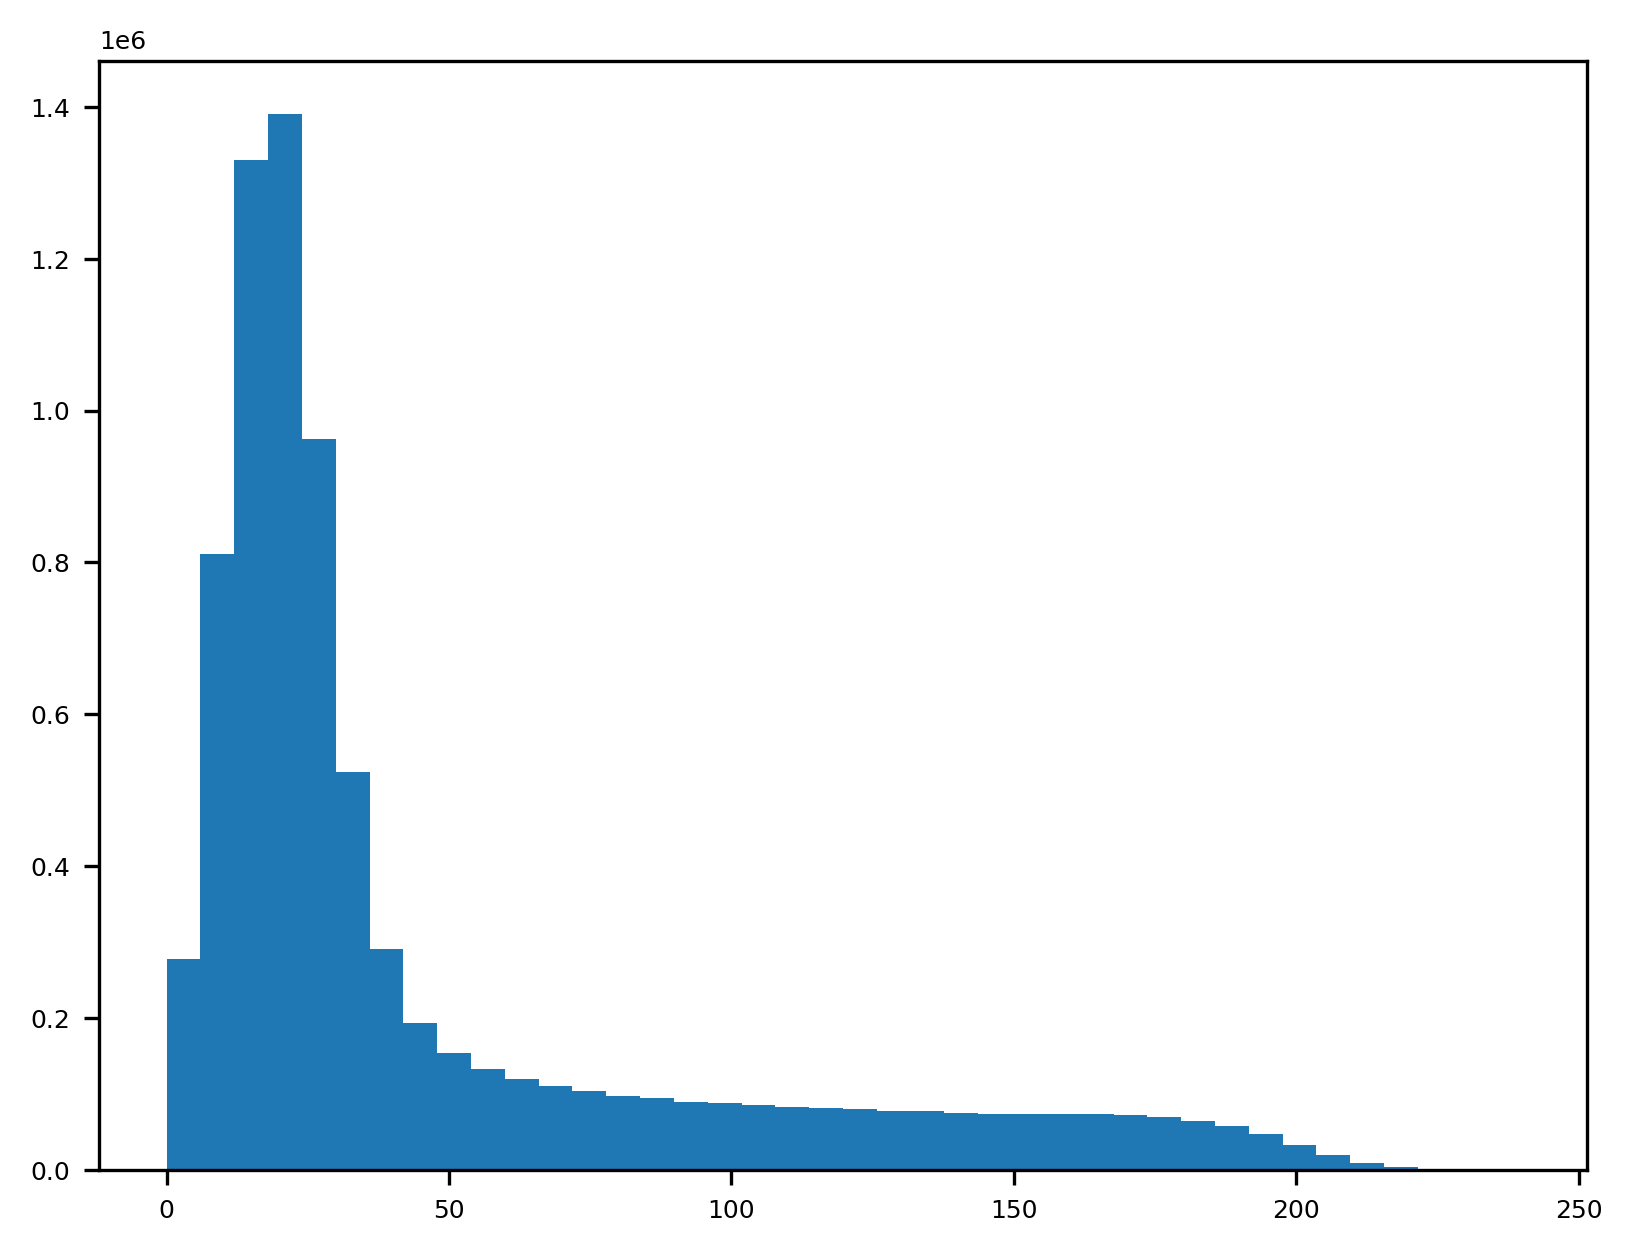

In [14]:
# plot the input image histogram
fig2, ax2 = plt.subplots()
plt.hist(data_3D.ravel(), bins=40)
plt.show()

Apply single global threshold obtained from comparison with histology

In [15]:
#BW = data_3D > T
BW = data_3D > 63 # from comparison with histology

Have a look at the binarized dataset

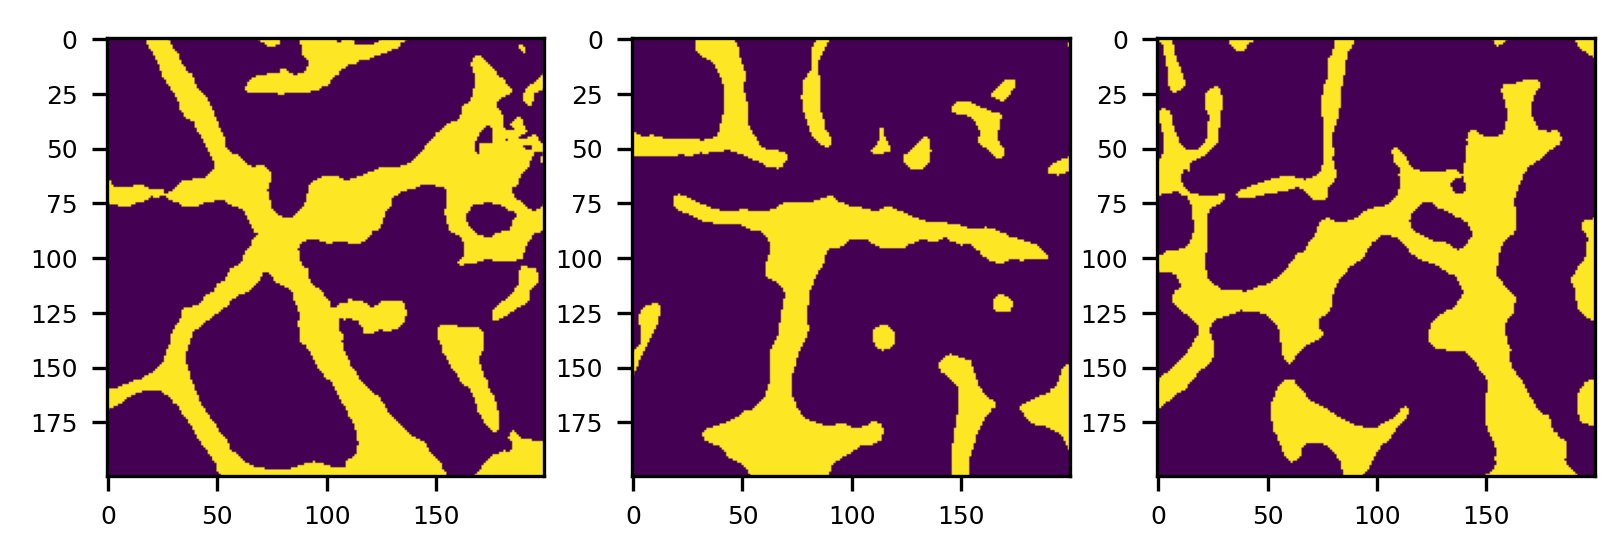

In [16]:
plot_midplanes(BW)
plt.show()

### Morphological close of binary image (optional)

In [17]:
# BW = morphology.closing(BW, morphology.ball(3))

In [18]:
#plot_midplanes(BW)
#plt.show()

### Detect largest isolated cluster of voxels
The procedure is described by the following 3 steps:
1. Label the BW 3D image

In [19]:
# [labels, n_labels] = measure.label(BW, None, True, 1) # 1 connectivity hop

2. Count the occurrences of each label

In [20]:
# occurrences = np.bincount(labels.reshape(labels.size))

3. Find the largest unconnected label

In [21]:
# largest_label_id = occurrences[1:].argmax()+1
# L = labels == largest_label_id

You can do the same using the function `remove_unconnected` contained in `ciclope.utils.preprocess`

In [22]:
L = remove_unconnected(BW)

Inspect dataset

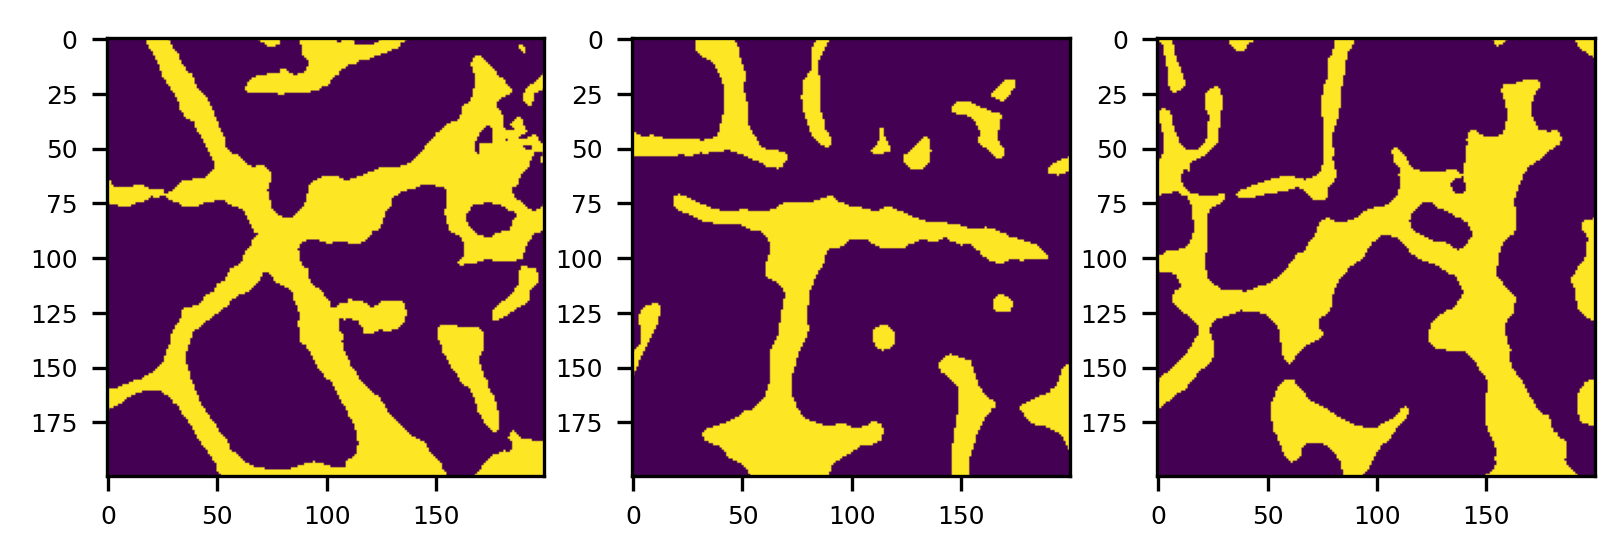

In [23]:
plot_midplanes(L)
plt.show()

## Write ParOSol output FE files
### Generate voxel-FE model with constant material properties

In [24]:
output_file = './../../test_data/LHDL/3155_D_4_bc/results/3155_D_4_bc.h5'

In [25]:
ciclope.core.voxelFE.vol2h5ParOSol(
    L, output_file,
    -0.04, vs, 0.3, 18e3,
    True, locking_strategy="plane", plane_lock_num=10, verbose=True
)

INFO:root:Opening Output file
INFO:root:creating h5 Image_Data Group
INFO:root:Setting voxel size
INFO:root:Setting Poisson ratio
INFO:root:h5 export done!


## Solve FE model in ParOSol
The following section assumes that the ParOSol solver is installed and accessible via terminal on a Linux operating system.
For running procedure of the .h5 file with ParOSol you can find useful information at [parosol-tu-wien](https://github.com/reox/parosol-tu-wien/tree/master) and [here](https://github.com/reox/parosol-tu-wien/tree/master/doc).
The multithread option of ParOSol is activated by defining the number of processors -np (default=1) used for the calculation.
It is recommended to set half of the total number of available logical processors for maximum performance.

---
## Post-processing of FE results
### Read ParOSol output and Reaction forces
The following sections assume that you have **h5py** and **Paraview** installed and working.<br /> For more info visit: <br />
- [https://www.paraview.org/](https://www.paraview.org/)
- [https://github.com/h5py/h5py](https://github.com/h5py/h5py)

In [26]:
plane_lock_num = 10
slice_level = plane_lock_num + 1

In [27]:
results = reaction_forces(output_file, slice_level)

### Apparent elastic modulus
`E_app = (F_tot / A) / epsilon`

In [28]:
A = 200*0.0195*200*0.0195 # [mm2]
epsilon = 0.04/(200*0.0195)

In [29]:
E = (results['F_tot']/A)/epsilon
print(f"E = {E:.2f} MPa")

E = 1720.73 MPa


Bone volume fraction

In [30]:
BVTV = 100*np.sum(L)/L.size
print(f"{BVTV:.2f} %")

23.37 %


#### Visualize results in Paraview

In [31]:
#!paraview {filename_out_base + '.vtk'}

![UMAG_displacements](./../../test_data/LHDL/3155_D_4_bc/results/LHDL_voxelFE_cyl_UMAG.png)

Visuailzation with itkwidgtes (does not show field data..)

In [32]:
# reader = vtk.vtkUnstructuredGridReader()
# reader.SetFileName(filename_vtk)
# reader.Update()
# grid = reader.GetOutput()

In [33]:
# view(geometries=grid)

---
## Dependencies

In [34]:
import watermark

In [35]:
%load_ext watermark

%watermark
%watermark --iversions

Last updated: 2025-07-17T15:06:32.609178+02:00

Python implementation: CPython
Python version       : 3.11.11
IPython version      : 8.21.0

Compiler    : MSC v.1942 64 bit (AMD64)
OS          : Windows
Release     : 10
Machine     : AMD64
Processor   : AMD64 Family 23 Model 49 Stepping 0, AuthenticAMD
CPU cores   : 64
Architecture: 64bit

skimage   : 0.25.1
mcubes    : 0.1.6
ciclope   : 1.3.5
numpy     : 1.26.4
h5py      : 3.12.1
matplotlib: 3.10.0
watermark : 2.5.0
meshio    : 5.0.0
sys       : 3.11.11 | packaged by conda-forge | (main, Dec  5 2024, 14:06:23) [MSC v.1942 64 bit (AMD64)]
scipy     : 1.13.1



---
# References
<a name="Bourne-2004"></a>
1. Bourne, Benjamin C., and Marjolein C. H. van der Meulen. 2004. “Finite Element Models Predict Cancellous Apparent Modulus When Tissue Modulus Is Scaled from Specimen CT-Attenuation.” Journal of Biomechanics 37 (5): 613–21. https://doi.org/10.1016/j.jbiomech.2003.10.002.
<a name="Cox-2022"></a>
2. Cox, Jason M., Joshua D. Smith, Marjolein C. H. van der Meulen, and Jacqueline H. Cole. 2022. “Heterogeneous Tissue Modulus Improved Prediction of Mechanical Behavior in Osteoporotic Vertebral Cancellous Bone.” bioRxiv. https://doi.org/10.1101/2021.11.30.470675.

---
# Acknowledgements
- This notebook was developed within [Building the Jupyter Community in MSK Imaging Research](https://github.com/JCMSK/2022_JCW), a Jupyter Community Workshop sponsored by [NUMFocus](https://numfocus.org/)